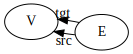

In [1]:
using GATlab, Catlab.Theories
using Catlab.CategoricalAlgebra
using Catlab.Graphs
using Catlab.Graphics

draw(g; kw...) = to_graphviz(g; node_labels=true, edge_labels=true, kw...)
draw(f::ACSetTransformation; kw...) =
  to_graphviz(f; node_labels=true, edge_labels=true, draw_codom=false, kw...)

to_graphviz(SchGraph)

# The Category of Graphs

The Theory of Graphs is given by the following Schema:
```julia
@present SchGraph(FreeSchema) begin
  V::Ob
  E::Ob
  src::Hom(E,V)
  tgt::Hom(E,V)
end

""" Abstract type for graphs, aka directed multigraphs.
"""
@abstract_acset_type AbstractGraph <: HasGraph

""" A graph, also known as a directed multigraph.
"""
@acset_type Graph(SchGraph, index=[:src,:tgt]) <: AbstractGraph
```

That is all we need to do to generate the functor category [SchGraph, FinSet].
Catlab knows how to take a finitely presented category and generate all the data structures
that you need to represent functors into FinSet and natural transformations between those functors.
Note: the index=[:src, :tgt] keyword argument tells Catlab that you want to have an efficient index
the preimages of those morphisms. in this example, we want to be able to find the incoming and
outgoing edges of a vertex in O(1) time.

## Creating some Graphs

Once you have fixed the schema (aka indexing category or theory), you can make some instances.
Catlab has a DSL for specifying instances of any schema. It is called `@acset`.
In order to specify a Functor F=(F₀, F₁) into FinSet, you need to provide some data.
    1. For every A:Ob(C), you need F₀(A):FinSet
    2. For every f:A→B, you need to specify a FinFunction F₁(f):F₀(A)→F₀(B)
If the theory C has some equations, the data you provide would have to also satisfy those equations.
The theory of graphs has no equations, so there are no constraints on the data you provide,
except for those that come from functoriality.

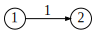

In [2]:
e = @acset Graph begin
    V = 2
    E = 1
    src = [1]
    tgt = [2]
end

draw(e)

a wedge is two edges that share a target

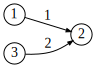

In [3]:
w = @acset Graph begin
    V = 3
    E = 2
    src=[1,3]
    tgt=[2,2]
end

draw(w)

The CSet API generalizes the traditional Graph API

In [4]:
parts(w, :V)  # vertex set

parts(w,:E) # edge set

w[:src] # source map

w[:tgt] # target map


incident(w, 1, :src) # edges out of vertex 1

incident(w, 2, :tgt) # edges into vertex 2

w[incident(w, 2, :tgt), :src] # vertices that are the source of edges whose target is vertex 2

w[incident(w, 1, :src), :tgt] # vertices that are the target of edges whose src is vertex 1

1-element Vector{Int64}:
 2

### Exercise:
1. Use the @acset macro to make a graph with at least 5 vertices
2. Draw the graph
3. Compute in neighbors and out neighbors and make sure they match your expectations.
4. Write a function that computes the 2-hop out-neighbors of a vertex.

# Graph Homomorphisms
We can construct some graph homomorphisms between our two graphs.
What data do we need to specify?

In [5]:
ϕ = ACSetTransformation(e,w,E=[1], V=[1,2])

is_natural(ϕ)

true

The ACSetTransformation constructor does not automatically validate that the naturality squares commute!

In [6]:
ϕᵦ = ACSetTransformation(e,w,E=[1], V=[3,2])
is_natural(ϕᵦ)

false

Our ϕᵦ in't natural because the edge map e₁ ↦ e₁ is not consistent with our vertex map, which sends v₁ ↦ v₃ and v₂ ↦ v₂. We can fix this by sending e₁ to e₂

In [7]:
ϕᵦ′ = ACSetTransformation(e,w,E=[2], V=[3,2])
is_natural(ϕᵦ′)

true

So how does Catlab store the data of the natural transformation?
the domain

In [8]:
ϕ.dom

E,src,tgt
1,1,2


the codomain

In [9]:
ϕ.codom

E,src,tgt
1,1,2
2,3,2


the components

In [10]:
ϕ.components

(V = FinFunction([1, 2], 2, 3), E = FinFunction([1], 1, 2))

you can see the components using standard indexing notation with the object names. Notice that while CSets are indexed by morphisms, natural transformations are indexed by objects.

In [11]:
ϕ[:V]
ϕ[:E]

FinFunction([1], 1, 2)

We can check the  naturality squares ourselves
The sources are preserved: `src ⋅ ϕᵥ == ϕₑ ⋅ src`

In [12]:
ϕ[:V](dom(ϕ)[:,:src]) == codom(ϕ)[collect(ϕ[:E]), :src]

true

The targets are preserved: `tgt ⋅ ϕᵥ == ϕₑ ⋅ tgt`

In [13]:
ϕ[:V](dom(ϕ)[:,:tgt]) == codom(ϕ)[collect(ϕ[:E]), :tgt]

true

This approach generalizes to the following:

```julia
function is_natural(α::ACSetTransformation{S}) where {S}
   X, Y = dom(α), codom(α)
   for (f, c, d) in zip(hom(S), dom(S), codom(S))
     Xf, Yf, α_c, α_d = subpart(X,f), subpart(Y,f), α[c], α[d]
     all(Yf[α_c(i)] == α_d(Xf[i]) for i in eachindex(Xf)) || return false
   end
   return true
end
```

Notice how we iterate over the homs in the schema category S `(f, c, d) in zip(hom(S), dom(S), codom(S))` We get one universally quantified equation `all(Yf[α_c(i)] == α_d(Xf[i]) for i in eachindex(Xf))` for each morphism in the indexing category

### Exercise:
1. Take your graph from the previous exercise and construct a graph homomorphism from the wedge (w) into it.
2. Check that the naturality equations are satisfied.
3. Explain why we don't need to specify any data for the source and target morphisms in SchGraph when definining a graph homomorphism

## Finding Homomorphisms Automatically
As you saw in the previous exercise, constructing a natural transformation can be quite tedious. We want computers to automate tedious things for us. So we use an algorithm to enumerate all the homomorphisms between two CSets.

CSet homomorphisms f:A→B are ways of finding a part of B that is shaped like A. You can view this as pattern matching. The graph A is the pattern and the graph B is the data. A morphism f:A→B is a collection of vertices and edges in B that is shaped like A. Note that you can ask Catlab to enforce constraints on the homomorphisms it will find including computing monic (injective) morphisms by passing the keyword `monic=true`. A monic morphism into B is a subobject of B.  You can pass `iso=true` to get isomorphisms.

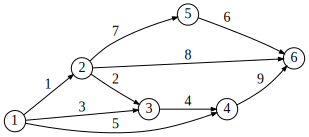

In [14]:
t = @acset Graph begin
    V = 3
    E = 3
    src = [1,2,1]
    tgt = [2,3,3]
end

draw(t)

T = @acset Graph begin
    V = 6
    E = 9
    src = [1,2,1, 3, 1,5,2,2,4]
    tgt = [2,3,3, 4, 4,6,5,6,6]
end

draw(T)

The simplest pattern in a graph is just a single edge and each homomorphism ϕ:e→G is a single edge in G.

In [15]:
length(homomorphisms(e, T, monic=true)) == nparts(T,:E) # number of edges


length(homomorphisms(t, T))

3

We can define this helper function to print out all the homomorphisms between graphs. Because all our graphs are simple, we only need to look at the vertex components.

In [16]:
graphhoms(g,h) = begin
    map(homomorphisms(g,h)) do ϕ
        collect(ϕ[:V])
    end
end

graphhoms(t, T)

3-element Vector{Vector{Int64}}:
 [1, 2, 3]
 [1, 3, 4]
 [2, 5, 6]

Homs ϕ:t→T are little triangles in T, but homs ϕ:T→t are colorings of T with 3 colors. The fact that there are edges in t that are missing, means that it provides constraints on what graphs have morphisms into it. For example, there are no morphisms T→t.

In [17]:
graphhoms(T, t)

Any[]

The reason we don't have a morphism into t is vertices 2,3,4,5 aren't arranged into a triangle. We can relax those constraints by adding loops to the codomain. Loops in the codomain allow you to merge adjacent vertices when you construct the homomorphism.

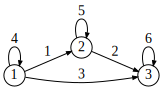

In [18]:
add_loops!(g) = add_parts!(g, :E, nparts(g,:V), src=parts(g,:V), tgt=parts(g,:V))
add_loops(g) = begin
    h = copy(g)
    add_loops!(h)
    return h
end

draw(add_loops(t))

Once we add loops, then we have morphisms.

In [19]:
length(homomorphisms(T,add_loops(t)))

42

## Bipartite Graphs
Many computer science problems involve graphs that have two types of vertices. For example, when matching students to classes, you might represent the students as one type of vertex and the classes as another type of vertex. Then the edges (s,c) represent "student s is enrolled in class c". In this scenario there can be no edges from a class vertex to another class vertex, or from a student vertex to a student vertex. Graphs for which there exists such a classification are called bipartite graphs. In Category Theory, we shift from thinking about graphs with properties to graph homomorphisms that witness that property and think of bipartitioned graphs.

First we construct a bipartite graph:

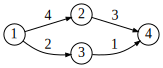

In [20]:
sq = apex(product(add_loops(e), add_loops(e)))
rem_parts!(sq, :E, [1,5,6,8,9])
draw(sq)

We will use the symmetric edge graph to identify the bipartitions of this graph.

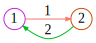

In [21]:
esym = @acset Graph begin
    V = 2
    E = 2
    src = [1,2]
    tgt = [2,1]
end

draw(id(esym))

There are two ways to bipartition sq.

In [22]:
graphhoms(sq, esym)

2-element Vector{Vector{Int64}}:
 [1, 2, 2, 1]
 [2, 1, 1, 2]

This comes from the fact that esym has 2 automorphisms!

In [23]:
graphhoms(esym, esym)

2-element Vector{Vector{Int64}}:
 [1, 2]
 [2, 1]

the first coloring

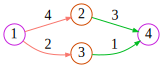

In [24]:
draw(homomorphisms(sq, esym)[1])

but we can also swap the roles of the colors

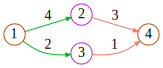

In [25]:
draw(homomorphisms(sq, esym)[2])

### Exercise:
1. Construct a graph representation of a checkerboard
2. Draw the two bipartitions of the checkerboard

We can generalize the notion of Bipartite graph to any number of parts. I like to call Kₖ the k-coloring classifier because homomorphims into α:G → Kₖ are k-colorings of G.

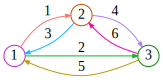

In [26]:
clique(k::Int) = begin
    Kₖ = Graph(k)
    for i in 1:k
        for j in 1:k
            if j ≠ i
                add_parts!(Kₖ, :E, 1, src=i, tgt=j)
            end
        end
    end
    return Kₖ
end

K₃ = clique(3)
draw(id(K₃))

Our graph T is not 2-colorable,

In [27]:
length(homomorphisms(T, esym))

0

but we can use 3 colors to color T.

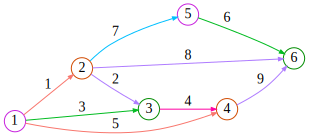

In [28]:
draw(homomorphism(T, K₃; any=true))

### Exercise:
1. Find a graph that is not 3-colorable
2. Find a graph that is not 4-colorable

## Homomorphisms in [C, Set] are like Types
Any graph can play the role of the codomain. If you pick a graph that is incomplete, you get a more constrained notion of coloring where there are color combinations that are forbidden.

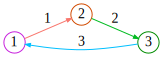

In [29]:
triloop = @acset Graph begin
    V = 3
    E = 3
    src = [1,2,3]
    tgt = [2,3,1]
end

draw(id(triloop))

With this graph, we can pick out directed 3-cycles in a graph like T2,

In [30]:
T2 = @acset Graph begin
    V = 6
    E = 6
    src = [1,2,3,4,5,6]
    tgt = [2,3,1,5,6,4]
end
graphhoms(T2, triloop)

9-element Vector{Vector{Int64}}:
 [1, 2, 3, 1, 2, 3]
 [1, 2, 3, 2, 3, 1]
 [1, 2, 3, 3, 1, 2]
 [2, 3, 1, 1, 2, 3]
 [2, 3, 1, 2, 3, 1]
 [2, 3, 1, 3, 1, 2]
 [3, 1, 2, 1, 2, 3]
 [3, 1, 2, 2, 3, 1]
 [3, 1, 2, 3, 1, 2]

and we can draw those cyclic roles with colors

In [31]:
draw(homomorphisms(T2, triloop)[1])

T3 = @acset Graph begin
    V = 6
    E = 7
    src = [1,2,3,4,5,6, 2]
    tgt = [2,3,1,5,6,4, 4]
end
graphhoms(T3, triloop)

3-element Vector{Vector{Int64}}:
 [1, 2, 3, 3, 1, 2]
 [2, 3, 1, 1, 2, 3]
 [3, 1, 2, 2, 3, 1]

Using the colors as shown:

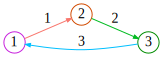

In [32]:
draw(id(triloop))

We can see our coloring of T3:

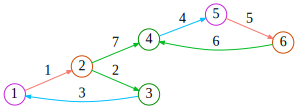

In [33]:
draw(homomorphisms(T3, triloop)[1])